In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

import re

from nltk import bigrams, trigrams, ngrams, word_tokenize
from nltk.corpus import stopwords

from string import punctuation

from collections import defaultdict

from itertools import chain # Con esto vamos a juntas todos los ngramas en un corpus...

In [24]:
df = pd.read_csv("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4417 non-null   int64 
 1   Title       4416 non-null   object
 2   Opinion     4415 non-null   object
 3   Place       4417 non-null   object
 4   Gender      4417 non-null   object
 5   Age         4417 non-null   int64 
 6   Country     4417 non-null   object
 7   Date        4417 non-null   object
 8   Label       4417 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 310.7+ KB


In [25]:
# Hay unos valores nulos pero no coinciden... así que al unir Title y Opinion no se afectará el resultado...
print("Title: \n", df["Title"][df["Title"].isnull()])
print("Opinion: \n", df["Opinion"][df["Opinion"].isnull()])

Title: 
 2209    NaN
Name: Title, dtype: object
Opinion: 
 1142    NaN
3712    NaN
Name: Opinion, dtype: object


In [63]:
# Examindando las labels... hay un desvalance grande... apenas el 17.5% son negativas...
df["Label"].value_counts()

Label
1    3643
0     774
Name: count, dtype: int64

In [26]:
# Vamos a unir las columnas de texto en cuestión para la primera prueba...
# Crear una función para concatenar las columnas "Title" y "Opinion"...
def concatenate_columns(row):
    # Convertir ambos valores a cadenas, si son None o NaN, los convertirá en una cadena vacía...
    title = str(row["Title"]) if pd.notna(row["Title"]) else ""
    opinion = str(row["Opinion"]) if pd.notna(row["Opinion"]) else ""

    if (title != "") and (opinion != ""):
        return title + ". " + opinion
    elif (title == ""):
        return opinion
    elif (opinion == ""):
        return title

df["Texto"] = df.apply(concatenate_columns, axis=1)

In [27]:
# Resuelto...
print(df["Texto"][1142])
print(df["Texto"][2209])
print(df["Texto"][3712])

Lugar lleno de historia
De los lugares más bonitos de Guanajuato, a un costado del Teatro Juárez, visita obligatoria en Guanajuato
punto cental


In [28]:
# Eliminando las comillas dobles en el texto final, si existen...
df["Texto"] = df["Texto"].str.replace('"', '')

# Mostrar el resultado...
df["Texto"][0]

'No es para recomendarse. Las famosas momias de Guanajuato. El museo en sí es horrible, y no por lo que exhiben sino como lo exhiben. Mi abuelo me contó que hace 40 años para visitar las momias había que entrar al panteón pasear entre las tumbas y darle una propina al sepulturero que levantaba una pesada aldaba para después bajar por una escalera de caracol a la lúgubre cripta. Ahí los cuerpos alineados uno tras otro y a ambos lados de un estrecho pasillo había que pasar entre ellas sin cristales de por medio. Suena más escalofriante pero mucho más auténtico... lo debieron haber dejado así y limitar el número de personas que las pudieran visitar diariamente quizás unas 100 y haber cobrado más. Pero bueno se ve que el museo es una muy buena fuente de ingresos para el erario de esta bella ciudad. Recomiendo visitarlo sí y sólo si ya visitaron todas las demás atracciones y bellezas que ofrece Guanajuato si les queda tiempo pues esta bien.'

In [29]:
# Vamos a eliminar la columna Unnamed, que contenía Índices...
df.drop('Unnamed: 0', axis=1, inplace= True)

Sobre algunos conceptos mencionados en clases, en relación con el preprocesamiento del texto, surgió la idea de agragar las etiquetas <SOS>, <EOS> y <UNK>. Solo agregaremos <SOS> y <UNK>, ya que consideramos que agregar <EOS> crearía 2-gramas <EOS> <SOS> que no servirían de mucho... al menos en lo que a 2-gramas respecta. Igual se valorará que hacer más adelante... 

In [30]:
# Definir una función para agregar <SOS> delante de cada palabra que inicie una oración
def add_sos(text):
    # Expresión regular para encontrar el inicio de una oración
    modified_text = re.sub(r'(?<!\w)([A-Z][a-z]*\b)', r'startofsentence \1', text)
    return modified_text

# Aplicar la función a la columna de texto
df["Texto"] = df["Texto"].apply(add_sos)

In [31]:
# Creando un set con los signos de puntuación...
punctuations = set(punctuation)
# punctuations

In [32]:
# Obtener las stopwords en español...
stop_words_spanish = set(stopwords.words('spanish'))

# De la lista de Stop words vamos a eliminar unas cuantas que quizás si aporten algo al contexto...
preservar = set(['algo', 'algunas', 'algunos', 'contra', 'fue', 'fueron', 'mucho', 'muchos', 'muy', 'más', 'nada', 'ni', 'no', 'pero', 'poco', 'sí', 'también', 'tanto', 'todo', 'todos'])

sw_final = stop_words_spanish - preservar
sw_final = sorted(sw_final)

# Mostrar algunas de las stopwords a eliminar...
# print(len(sw_final), sw_final)

In [33]:
# Hasta aquí muy fácil... ahora vamos a ver que palabras son menos frecuentes y sustituirlas por <UNK>
# Pero primero hay que Tokenizar...

# Crear una función para tokenizar y eliminar signos de puntuación
def tokenize_and_remove_punctuation(text):
    # Convertir a minúsculas y tokenizar el texto
    tokens = word_tokenize(text.lower())
    
    # Eliminar signos de puntuación...
    tokens = [word for word in tokens if word not in punctuations] 
    
    # Mantener solo palabras alfabéticas...
    tokens = [word for word in tokens if word.isalpha()]

    # Eliminar las stopwords acordadas...
    tokens = [word for word in tokens if word not in sw_final]

    # Eliminar palabras de 1 solo caracter, que se pudieron haber escapado...
    tokens = [word for word in tokens if len(word) > 1]
    
    return tokens

# Aplicar la función a la columna de texto modificado
df["Tokens"] = df["Texto"].apply(tokenize_and_remove_punctuation)

In [34]:
# Crear un defaultdict para contar palabras...
# Contar palabras nos da la medida de cual es el mínimo de ngramas que serán únicos...
# Sin embargo no es palabras lo que queremos contar, sino n-gramas...
# Sustituiremos las palabras que se encontraron solo una vez... al haber quedado el corpus tan pequeño (11 155 palabras después de eliminar stopwords),
# esta cifra es grande... 5718... Por "unknown"...

word_count = defaultdict(int)

# Recorrer todos los tokens y contar las palabras
for tokens in df["Tokens"]:
    for token in tokens:
        word_count[token.lower()] += 1

# Mostrar los conteos de palabras
# for word, count in word_count.items():
#    print(f"{word}: {count}")

# Convertir el diccionario en un DataFrame
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])

df_word_count.sort_values(by='count', ascending=False, inplace=True)

# Sacamos las palabras de 1 sola aparición... para sustituirlas por "unknown"...
# df_word_count[df_word_count["count"].apply(lambda x: x == 1)] # Si quisieramos ver el listado...

unknown = set(df_word_count.loc[df_word_count["count"].apply(lambda x: x < 11), "word"])
# len(unknown) # 5718.

# Aquí quiero sustituir por UNKNOWN...

# Crear una función para tokenizar y eliminar signos de puntuación
def sustituir_unknown(tokens):
    # Partimos de un texto ya tokenizado...
    
    # sustituir por "unknown"...
    tokens = [word if word not in unknown else "unknown" for word in tokens]
    
    return tokens

# Aplicar la función a la columna de texto modificado
df["Tokens"] = df["Tokens"].apply(sustituir_unknown)

In [35]:
# Démosle ya un vistazo al DataFrame...
df

,Title,Opinion,Place,Gender,Age,Country,Date,Label,Texto,Tokens
0,"""No es para recomendarse""","""Las famosas momias de Guanajuato. El museo en...",Museo de las Momias,Male,48,México,02/07/2013,0,startofsentence No es para recomendarse. start...,"[startofsentence, no, unknown, startofsentence..."
1,"""Es un mercado tradicional, no es nada del otr...","""Allí puedes encontrar comida o souvenirs. Es ...",Mercado Hidalgo,Male,52,México,06/09/2016,0,"startofsentence Es un mercado tradicional, no ...","[startofsentence, mercado, tradicional, no, na..."
2,"""No visitar""","""Es tardado entrar al museo, una vez dentro no...",Museo de las Momias,Male,42,México,25/12/2017,0,startofsentence No visitar. startofsentence Es...,"[startofsentence, no, visitar, startofsentence..."
3,"""No le veo atractivo. A ver semejantes cacharros""","""Entiendo que a muchos les cautive o llamé la ...",Museo de las Momias,Female,24,México,14/08/2013,0,startofsentence No le veo atractivo. startofse...,"[startofsentence, no, veo, atractivo, startofs..."
4,"""Nada fuera de lo común""","""La fruta y verdura son poco frescos, al igual...",Mercado Hidalgo,Female,19,México,01/08/2017,0,startofsentence Nada fuera de lo común. starto...,"[startofsentence, nada, común, startofsentence..."
...,...,...,...,...,...,...,...,...,...,...
4412,"""Beautiful architecture""","""This university is famous because of its beau...",Universidad de Guanajuato,Male,24,México,21/04/2014,1,startofsentence Beautiful architecture. starto...,"[startofsentence, unknown, unknown, startofsen..."
4413,"""Imponente la universidad, TODO guanajuato es ...","""Lo que no me gusto fue la comida, pero es muy...",Universidad de Guanajuato,Female,44,México,05/07/2015,1,"startofsentence Imponente la universidad, TODO...","[startofsentence, imponente, universidad, todo..."
4414,Lugar magico,Esta excelente para pasar a sentarse unos minu...,Jardín de la Unión,Male,-1,México,2018,1,startofsentence Lugar magico. startofsentence ...,"[startofsentence, lugar, unknown, startofsente..."
4415,"""¡Su fachada es hermosa!""","""No tuvimos la fortuna de entrar a verlo, ya q...",Teatro Juárez,Female,47,México,22/10/2012,1,¡startofsentence Su fachada es hermosa!. start...,"[fachada, hermosa, startofsentence, no, unknow..."


In [36]:
# Función para generar n-gramas a partir de una lista de tokens
def generate_ngrams(text, n):
    # Tokenizar el texto
    # tokens = word_tokenize(text.lower())
    
    # Generar los n-gramas
    n_grams = list(ngrams(text, n))
    
    return n_grams

In [37]:
# Crear las nuevas columnas con los n-gramas...
for n in range(2,6):
    df[f'n{n}-grams'] = df['Tokens'].apply(lambda x: generate_ngrams(x, n))

In [38]:
df

,Title,Opinion,Place,Gender,Age,Country,Date,Label,Texto,Tokens,n2-grams,n3-grams,n4-grams,n5-grams
0,"""No es para recomendarse""","""Las famosas momias de Guanajuato. El museo en...",Museo de las Momias,Male,48,México,02/07/2013,0,startofsentence No es para recomendarse. start...,"[startofsentence, no, unknown, startofsentence...","[(startofsentence, no), (no, unknown), (unknow...","[(startofsentence, no, unknown), (no, unknown,...","[(startofsentence, no, unknown, startofsentenc...","[(startofsentence, no, unknown, startofsentenc..."
1,"""Es un mercado tradicional, no es nada del otr...","""Allí puedes encontrar comida o souvenirs. Es ...",Mercado Hidalgo,Male,52,México,06/09/2016,0,"startofsentence Es un mercado tradicional, no ...","[startofsentence, mercado, tradicional, no, na...","[(startofsentence, mercado), (mercado, tradici...","[(startofsentence, mercado, tradicional), (mer...","[(startofsentence, mercado, tradicional, no), ...","[(startofsentence, mercado, tradicional, no, n..."
2,"""No visitar""","""Es tardado entrar al museo, una vez dentro no...",Museo de las Momias,Male,42,México,25/12/2017,0,startofsentence No visitar. startofsentence Es...,"[startofsentence, no, visitar, startofsentence...","[(startofsentence, no), (no, visitar), (visita...","[(startofsentence, no, visitar), (no, visitar,...","[(startofsentence, no, visitar, startofsentenc...","[(startofsentence, no, visitar, startofsentenc..."
3,"""No le veo atractivo. A ver semejantes cacharros""","""Entiendo que a muchos les cautive o llamé la ...",Museo de las Momias,Female,24,México,14/08/2013,0,startofsentence No le veo atractivo. startofse...,"[startofsentence, no, veo, atractivo, startofs...","[(startofsentence, no), (no, veo), (veo, atrac...","[(startofsentence, no, veo), (no, veo, atracti...","[(startofsentence, no, veo, atractivo), (no, v...","[(startofsentence, no, veo, atractivo, startof..."
4,"""Nada fuera de lo común""","""La fruta y verdura son poco frescos, al igual...",Mercado Hidalgo,Female,19,México,01/08/2017,0,startofsentence Nada fuera de lo común. starto...,"[startofsentence, nada, común, startofsentence...","[(startofsentence, nada), (nada, común), (comú...","[(startofsentence, nada, común), (nada, común,...","[(startofsentence, nada, común, startofsentenc...","[(startofsentence, nada, común, startofsentenc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,"""Beautiful architecture""","""This university is famous because of its beau...",Universidad de Guanajuato,Male,24,México,21/04/2014,1,startofsentence Beautiful architecture. starto...,"[startofsentence, unknown, unknown, startofsen...","[(startofsentence, unknown), (unknown, unknown...","[(startofsentence, unknown, unknown), (unknown...","[(startofsentence, unknown, unknown, startofse...","[(startofsentence, unknown, unknown, startofse..."
4413,"""Imponente la universidad, TODO guanajuato es ...","""Lo que no me gusto fue la comida, pero es muy...",Universidad de Guanajuato,Female,44,México,05/07/2015,1,"startofsentence Imponente la universidad, TODO...","[startofsentence, imponente, universidad, todo...","[(startofsentence, imponente), (imponente, uni...","[(startofsentence, imponente, universidad), (i...","[(startofsentence, imponente, universidad, tod...","[(startofsentence, imponente, universidad, tod..."
4414,Lugar magico,Esta excelente para pasar a sentarse unos minu...,Jardín de la Unión,Male,-1,México,2018,1,startofsentence Lugar magico. startofsentence ...,"[startofsentence, lugar, unknown, startofsente...","[(startofsentence, lugar), (lugar, unknown), (...","[(startofsentence, lugar, unknown), (lugar, un...","[(startofsentence, lugar, unknown, startofsent...","[(startofsentence, lugar, unknown, startofsent..."
4415,"""¡Su fachada es hermosa!""","""No tuvimos la fortuna de entrar a verlo, ya q...",Teatro Juárez,Female,47,México,22/10/2012,1,¡startofsentence Su fachada es hermosa!. start...,"[fachada, hermosa, startofsentence, no, unknow...","[(fachada,

In [71]:
# Ahora si vamos a contar n-gramas... "n2-gramas"...
# Tomaremos en cuenta solo los n-gramas que aparezcan al menos 11 veces...
# Este conteo puede confundir... ya que dice cuantas veces aparece el n-grama, pero no en cuantas reseñas diferentes...
# Pudo darse un caso en que en una sola reseña apareciera varias veces...
# Esto lo vamos a resolver más adelante...

n_grams_count = defaultdict(int)

# Recorrer todos los ngramas y contar las frecuencias...
for n_grams in df["n2-grams"]:
    for n_gram in n_grams:
        n_grams_count[n_gram] += 1

# Convertir el diccionario en un DataFrame
df_n_grams_count = pd.DataFrame(list(n_grams_count.items()), columns=['n-gram', 'count'])

df_n_grams_count.sort_values(by='count', ascending=False, inplace=True)
df_n_grams_count = df_n_grams_count[df_n_grams_count["count"] > 10]
df_n_grams_count

,n-gram,count
17,"(unknown, unknown)",5219
2,"(unknown, startofsentence)",2423
16,"(startofsentence, unknown)",1881
6,"(startofsentence, guanajuato)",1743
181,"(startofsentence, lugar)",743
...,...,...
5544,"(pero, todo)",11
5178,"(interesante, historia)",11
7339,"(unknown, calle)",11
8979,"(muy, startofsentence)",11


In [69]:
for _, row in df_n_grams_count.iterrows():
    ngram = row["n-gram"]
    print(ngram)

('unknown', 'unknown')
('unknown', 'startofsentence')
('startofsentence', 'unknown')
('startofsentence', 'guanajuato')
('startofsentence', 'lugar')
('no', 'unknown')
('startofsentence', 'muy')
('startofsentence', 'no')
('guanajuato', 'startofsentence')
('vale', 'pena')
('ciudad', 'startofsentence')
('muy', 'unknown')
('unknown', 'no')
('startofsentence', 'museo')
('startofsentence', 'visita')
('startofsentence', 'si')
('startofsentence', 'diego')
('startofsentence', 'excelente')
('lugar', 'unknown')
('visita', 'obligada')
('startofsentence', 'teatro')
('historia', 'startofsentence')
('unknown', 'muy')
('unknown', 'lugar')
('unknown', 'pero')
('startofsentence', 'rivera')
('diego', 'startofsentence')
('si', 'unknown')
('unknown', 'historia')
('vista', 'startofsentence')
('muy', 'bien')
('muy', 'bonito')
('más', 'unknown')
('si', 'vas')
('startofsentence', 'vista')
('lugar', 'startofsentence')
('guanajuato', 'unknown')
('museo', 'startofsentence')
('startofsentence', 'hermoso')
('no', 'p

In [72]:
# Crear un diccionario para almacenar los resultados
ngram_labels = defaultdict(list)

# Iterar sobre cada fila en df_word_count
for _, row in df_n_grams_count.iterrows():
    ngram = row["n-gram"]
    # Buscar el n-grama en la columna "n2-grams" del DataFrame df
    matching_labels = df[df["n2-grams"].apply(lambda x: ngram in x)]["Label"]
    
    # Almacenar los labels encontrados para este n-grama
    ngram_labels[ngram] = matching_labels.tolist()


# Convertir el diccionario en un DataFrame
df_n_grams_labels = pd.DataFrame(list(ngram_labels.items()), columns=['n-gram', 'Labels'])


# Mostrar los resultados
# for ngram, labels in ngram_labels.items():
#    print(f"N-grama: {ngram}, Labels: {labels}")


# df_n_grams_labels.sort_values(by='count', ascending=False, inplace=True)
# df_n_grams_labels[df_n_grams_count["count"] > 10]

In [82]:
# Una función para dar un valor numérico único a cada n-grama...
def valor_final(prop):
    if prop < 0.51:
        return -1
    elif prop >= 0.51 and prop < 0.75:
        return 1
    elif prop >= 0.75:
        return 1

df_n_grams_labels["Total"] = df_n_grams_labels["Labels"].apply(lambda x: len(x))
df_n_grams_labels["Positivas"] = df_n_grams_labels["Labels"].apply(lambda x: sum(x))
df_n_grams_labels["Prop_Pos"] = df_n_grams_labels["Labels"].apply(lambda x: round(sum(x) / len(x), 2))
df_n_grams_labels["Valor"] = df_n_grams_labels["Prop_Pos"].apply(valor_final)

df_n_grams_labels

,n-gram,Labels,Total,Positivas,Prop_Pos,Valor
0,"(unknown, unknown)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1988,1562,0.79,1
1,"(unknown, startofsentence)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1563,1221,0.78,1
2,"(startofsentence, unknown)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1291,1041,0.81,1
3,"(startofsentence, guanajuato)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1446,1237,0.86,1
4,"(startofsentence, lugar)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",688,582,0.85,1
...,...,...,...,...,...,...
1524,"(pero, todo)","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",11,9,0.82,1
1525,"(interesante, historia)","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",11,9,0.82,1
1526,"(unknown, calle)","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",11,9,0.82,1
1527,"(muy, startofsentence)","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",11,10,0.91,1


In [83]:
df_n_grams_labels["Valor"].value_counts()

Valor
 1    1426
-1     103
Name: count, dtype: int64

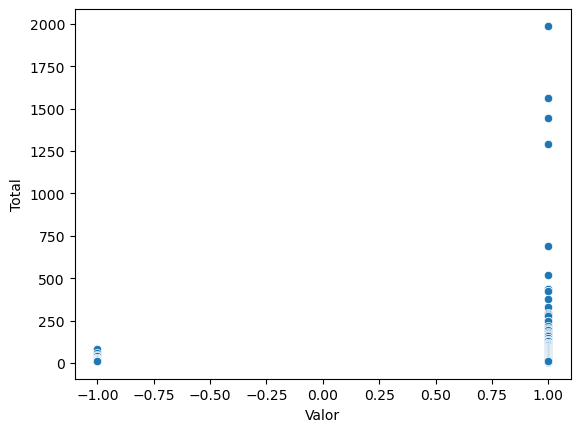

In [84]:
# Visualizando...
sns.scatterplot(data = df_n_grams_labels, x = "Valor", y = "Total")
plt.show()

In [ ]:
# Hacer un diccionario donde se tengan como claves los df_n_grams_labels["n-grams"] y como valores df_n_grams_labels["Valor"]...
# Mapear en el DataFrame de los ngramas...
# Calcular la suma...
# Determinar el umbral que se tomará para Positivo...
# Hacer la Crosstable de la Matriz de confusión...
# Calcular la métrica...